In [11]:
import pandas as pd
import numpy as np  
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from lazy_predict_runner import LazyPredictPipeline

In [9]:
sys.path.append("..")
from plotting_utils import save_figure

In [6]:
sys.path.append("../01_data_preparation")
from num_cat_data_transformers import PreprocessingPipeline

In [7]:
sys.path.append("../02_clustering/bertopic_modeling/")
from bertopic_mapper import merge_and_process

In [2]:
# docs_topics = './data/categorized_topic_doc_neighbors_200_cluster_50_samples_10_topic_size_500_vol_1.csv'
# all_data = './data/processed_data_all_vol_1.csv'

In [3]:
# merge_and_process(docs_topics, all_data)

In [11]:
df_bertopic = pd.read_csv('./data/processed_data_all_bertopic_vol_1.csv')

# change dtype of category to string in df_bertopic
df_bertopic['category'] = df_bertopic['category'].astype(str)

#### Checks

In [23]:
### Check with manually labelled subset whether bertopic is correct

# set 'category' data type as string
df_bertopic['category'] = df_bertopic['category'].astype(str)
# display data with category different than '-1'
df_check = df_bertopic[df_bertopic['category'] != '-1']
# return rows for which category is not equal to categoty_bertopic
df_check = (df_check[df_check['category'] != df_check['category_bertopic']])

Small fix - Overwrite category_bertopic with category (if category != -1)

In [25]:
# replace category bertopic with category if category is not equal to '-1' 
df_bertopic['category_bertopic'] = np.where(df_bertopic['category'] != '-1', df_bertopic['category'], df_bertopic['category_bertopic'])

In [30]:
df_bertopic.to_csv('./data/processed_data_all_bertopic_vol_1.csv', index=False)

##### Split data into labelled and unlabelled

In [27]:
# only the data that has been categorized by bertopic
df_bertopic_labeled = df_bertopic[df_bertopic['category_bertopic'] != '-1']

# only the data that has not been categorized by bertopic
df_bertopic_unlabeled = df_bertopic[df_bertopic['category_bertopic'] == '-1']

#### Subset to validate with stakeholders

In [28]:
df_bertopic_labeled['category_bertopic'].value_counts()

category_bertopic
C    11964
B     3561
A     2508
E      154
D      107
Name: count, dtype: int64

In [29]:
len(df_bertopic_labeled)

18294

In [28]:
# take 15 random samples from each bertopic category
df_bertopic_labeled_sample = df_bertopic_labeled.groupby('category_bertopic').apply(lambda x: x.sample(n=30, random_state=1)).reset_index(drop=True)

In [29]:
# drop columns from df_bertopic_labeled_sample expect for product_id, original_description, category_bertopic
df_bertopic_labeled_sample = df_bertopic_labeled_sample[['product_id', 'description_original', 'category_bertopic']]

In [30]:
df_bertopic_labeled_sample.to_csv('./data/processed_data_all_bertopic_labeled_sample.csv', index=False)

### EDA

In [31]:
# display he count for each category_bertopic
df_bertopic['category_bertopic'].value_counts()

category_bertopic
-1    16892
C     11964
B      3561
A      2508
E       154
D       107
Name: count, dtype: int64

In [32]:
# sum of products with label different than '-1' (i.e. categorized by bertopic)
df_bertopic_labeled['category_bertopic'].value_counts().sum()

18294

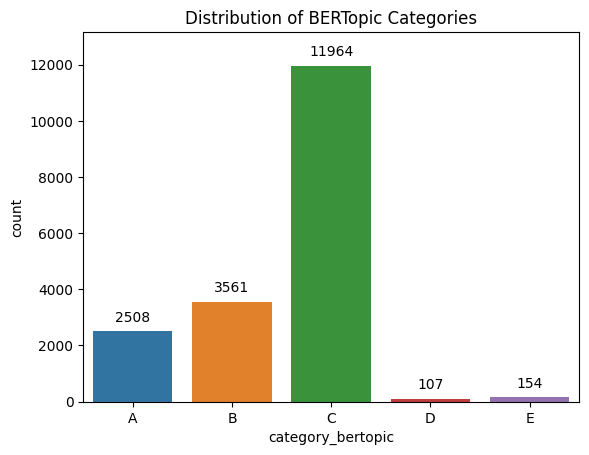

In [33]:
# Set order for categories
order = sorted(df_bertopic_labeled['category_bertopic'].unique())

ax = sns.countplot(data=df_bertopic_labeled, x='category_bertopic', order=order)
plt.title('Distribution of BERTopic Categories')

# Add counts on top of the bars
for p in ax.patches:
    height = int(p.get_height())  # Convert to integer
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10),  # Adjust this value to move label position
                textcoords='offset points')

# Adjust the ylim to fit the annotations
ax.set_ylim(0, 1.1*df_bertopic_labeled['category_bertopic'].value_counts().max())

# Save the figure using your function
save_figure(plt.gcf(), 'bertopic_labeled_category_distribution')

plt.show()

#### Boxplots with numerical features distributions

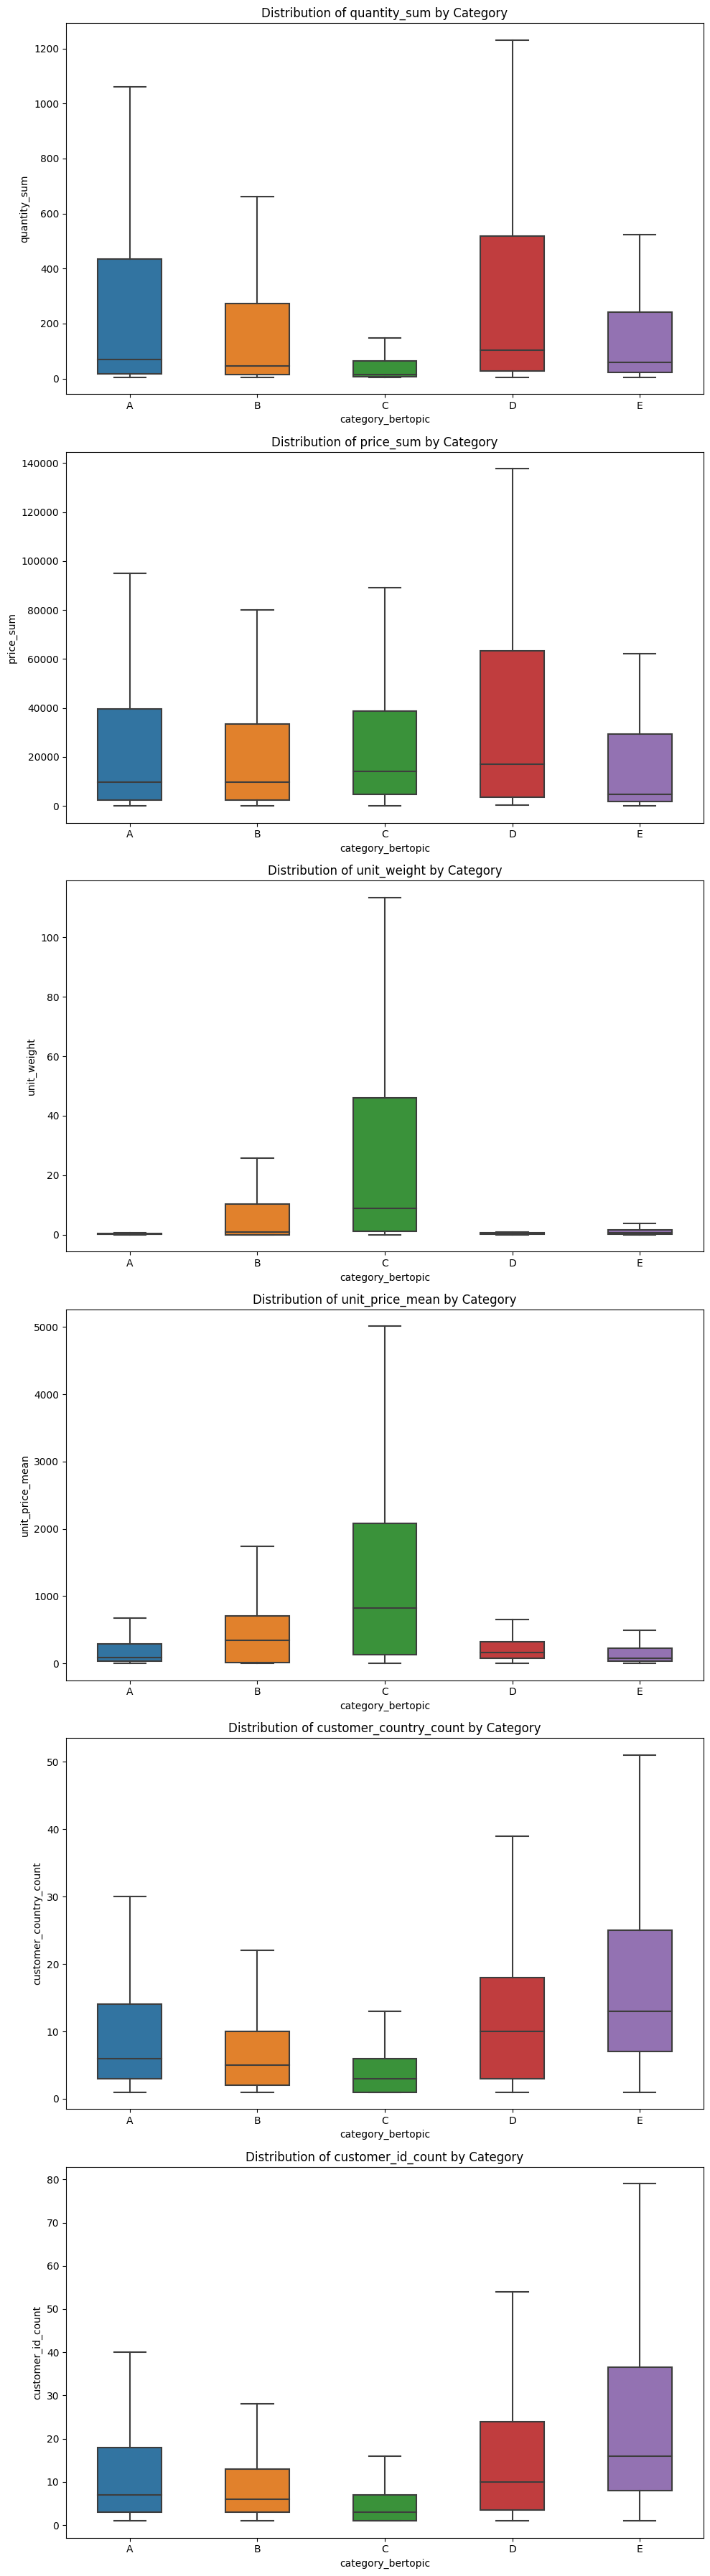

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_country_count', 'customer_id_count']

# Define the size of the entire figure
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 6 * len(numerical_features)))

# Set order for categories
order = sorted(df_bertopic_labeled['category_bertopic'].unique())

for idx, feature in enumerate(numerical_features):
    sns.boxplot(x='category_bertopic', y=feature, data=df_bertopic_labeled, width=0.5, showfliers=False, order=order, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature} by Category')
    axes[idx].set_ylabel(feature)  # Set the y-axis label for each subplot

# Adjust the layout
plt.tight_layout()

# Save the figure using your function
save_figure(fig, 'bertopic_labels_boxplot_all_num_feat')

plt.show()

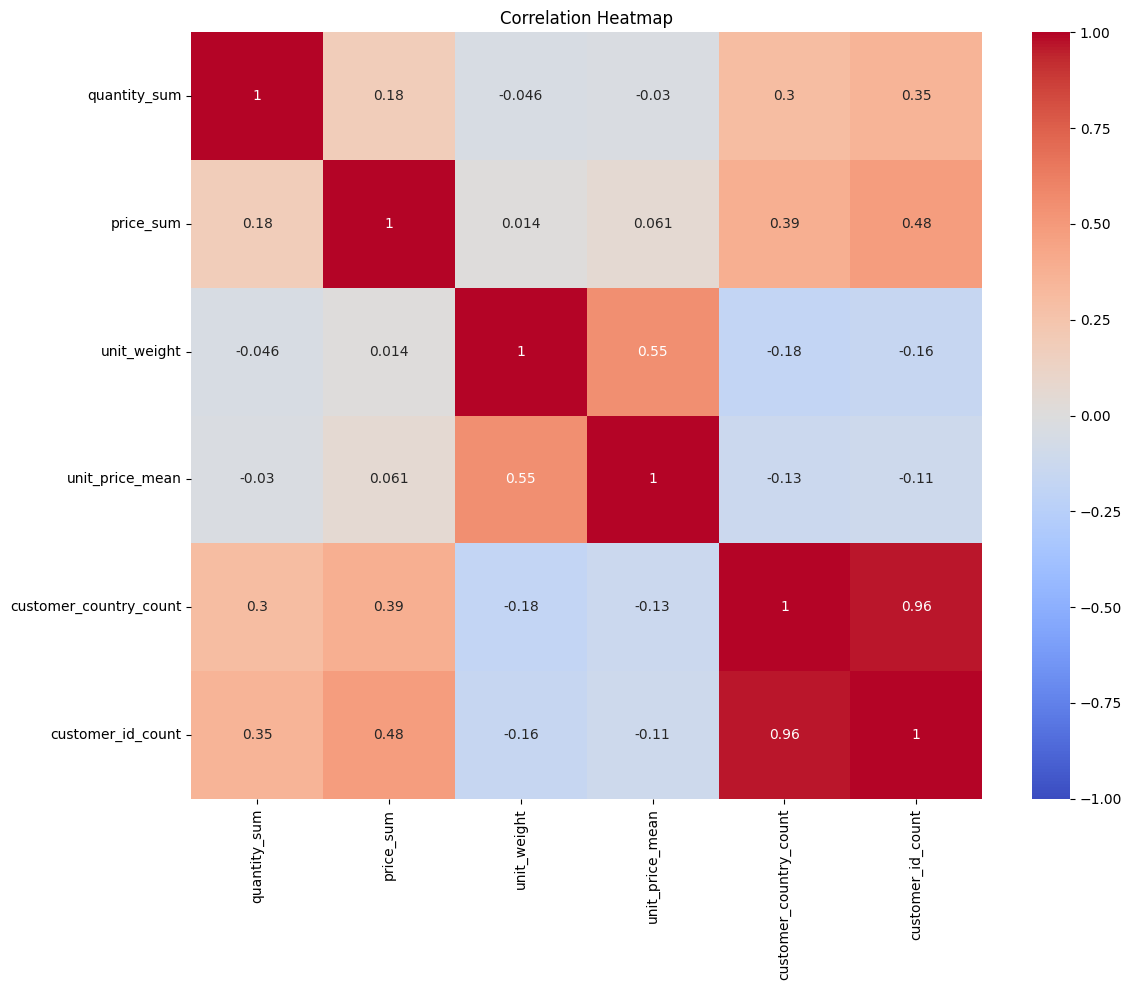

In [35]:
# Assuming you've already imported the necessary libraries and defined the save_figure function

plt.figure(figsize=(12,10))
sns.heatmap(df_bertopic_labeled[numerical_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

# Adjust the layout to ensure everything fits
plt.tight_layout()

# Save the figure using the save_figure function
fig = plt.gcf()  # Gets the current figure
save_figure(fig, 'bertopic_labeled_corr_feat_heatmap')

plt.show()

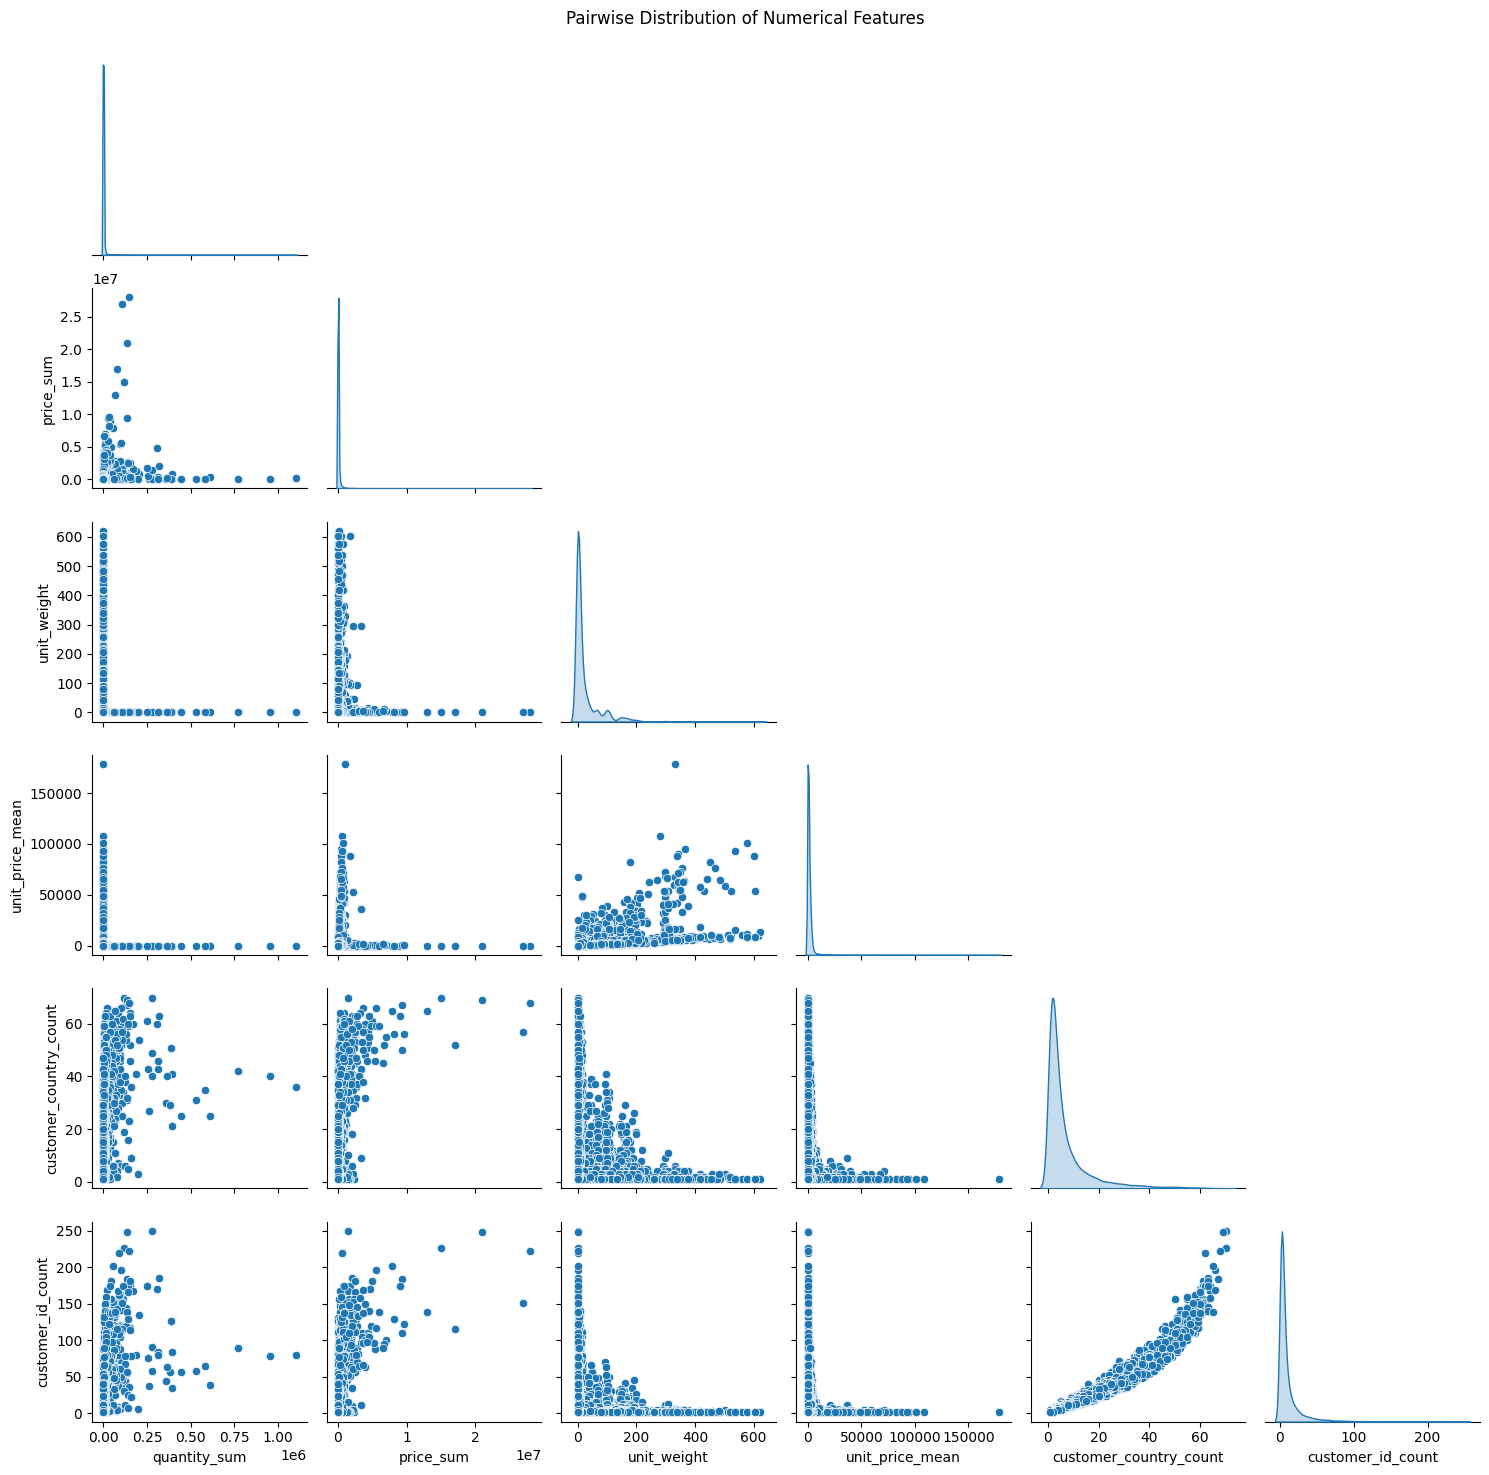

In [36]:
# Plotting pairplot
corr_plot = sns.pairplot(data=df_bertopic_labeled[numerical_features], diag_kind="kde", corner=True)

# Adjusting the layout to ensure everything fits well
plt.tight_layout()

# Add space at the top for the title
plt.subplots_adjust(top=0.95)

# Add a title above the plot using plt.suptitle()
plt.suptitle('Pairwise Distribution of Numerical Features')

# Saving the pairplot using save_figure function
save_figure(corr_plot.fig, 'bertopic_labeled_corr_dist_plot')

plt.show()


In [18]:
df_bertopic_labeled.head()

,product_id,description,month_mode,quarter_mode,year_mode,day_week_mode,quantity_sum,price_sum,unit_weight,customer_country_mode,customer_country_count,customer_id_count,category,unit_price_mean,description_original,topic,category_bertopic
5,010248,bfcf hanger welding buna,5,2,2014,1,150,558.00,0.00,NL,1,1,-1,3.72,B24FCF-1-U-S Hanger for weldi...,45,C
8,010260,bfcf hanger welding buna,12,4,2020,0,87,611.21,0.31,SE,2,4,-1,7.03,B24FCF-2 1/2-U-S Hanger for weldi...,45,C
9,010370,bfcf hanger welding buna,5,2,2014,1,530,1197.94,0.22,SE,4,5,-1,2.26,B24FCF-1/2-U-S HANGER FOR WELDI...,45,C
10,010375,bfcf hanger welding buna,12,4,2014,2,441,923.11,0.24,RU,3,3,-1,2.09,B24FCF-3/4-U-S Hanger for weldi...,45,C
11,010378,bfcf sfy hanger welding viton,9,3,2016,0,20,177.60,0.08,FR,1,1,-1,8.88,B24FCF-3/4-SFY-S HANGER FOR WELDI...,45,C


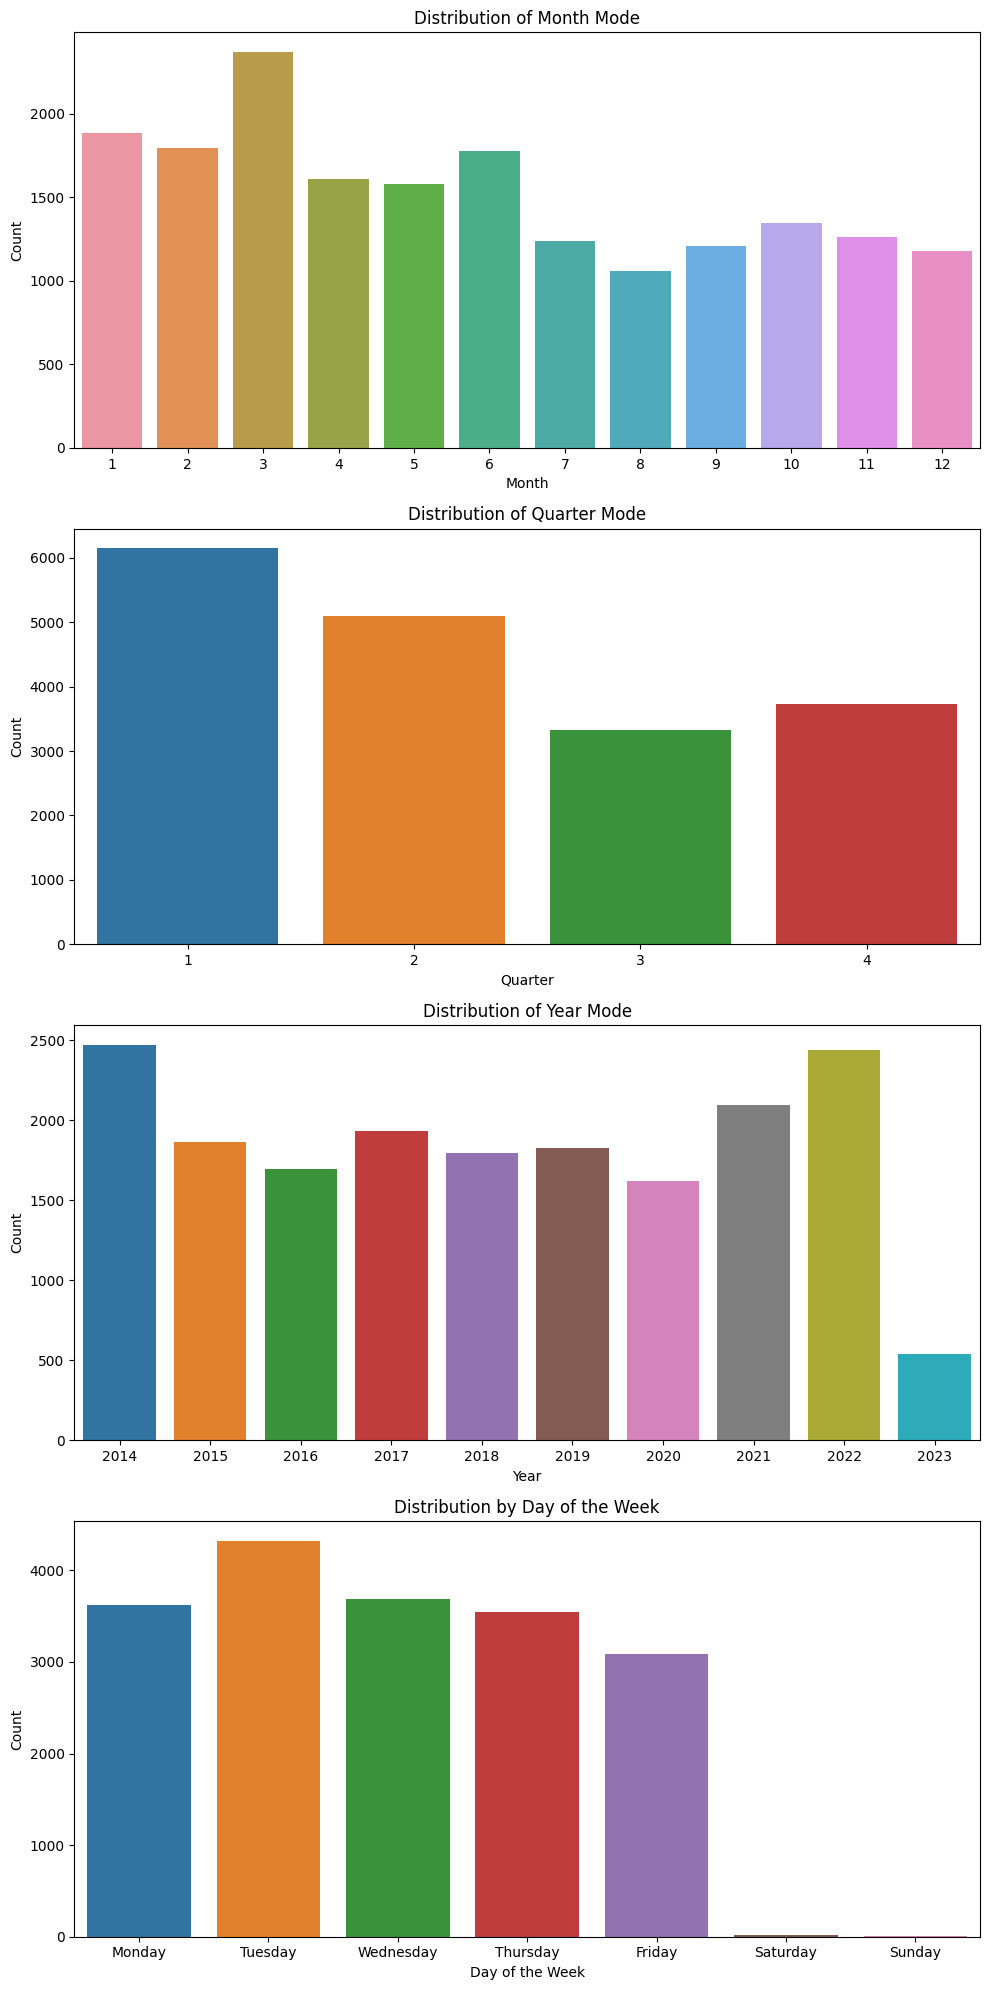

In [37]:
fig, ax = plt.subplots(4, 1, figsize=(10, 20))

# Month Mode
sns.countplot(data=df_bertopic_labeled, x='month_mode', ax=ax[0])
ax[0].set_title('Distribution of Month Mode')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Count')

# Quarter Mode
sns.countplot(data=df_bertopic_labeled, x='quarter_mode', ax=ax[1])
ax[1].set_title('Distribution of Quarter Mode')
ax[1].set_xlabel('Quarter')
ax[1].set_ylabel('Count')

# Year Mode
sns.countplot(data=df_bertopic_labeled, x='year_mode', ax=ax[2])
ax[2].set_title('Distribution of Year Mode')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Count')

# Day of the Week Mode
sns.countplot(data=df_bertopic_labeled, x='day_week_mode', ax=ax[3], order=[0, 1, 2, 3, 4, 5, 6])
ax[3].set_title('Distribution by Day of the Week')
ax[3].set_xlabel('Day of the Week')
ax[3].set_ylabel('Count')
ax[3].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6])
ax[3].set_xticklabels(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Adjust layout
plt.tight_layout()

# Save the figure
save_figure(fig, 'bertopic_labeled_time_mode_distributions')

# Display
plt.show()


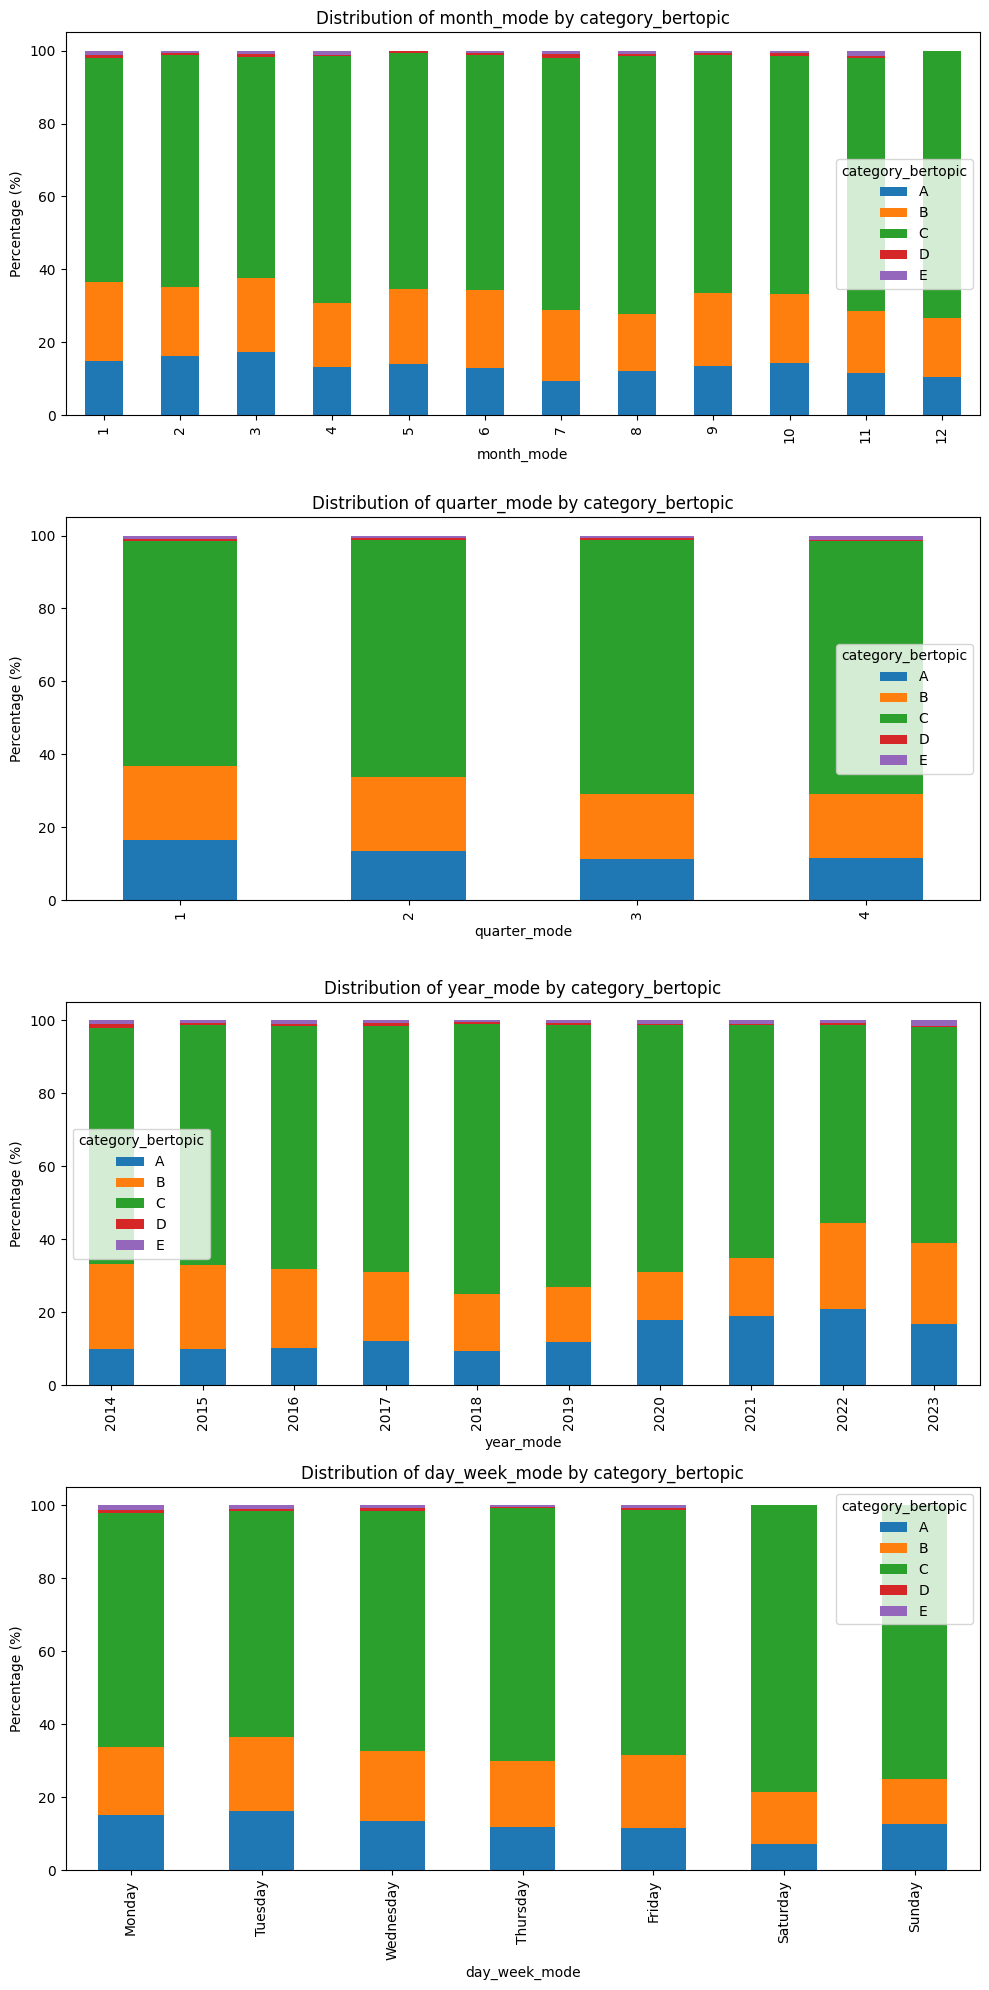

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_stacked_barchart(data, x_col, hue_col, ax, x_labels=None):
    # Calculate proportions
    ct = pd.crosstab(data[x_col], data[hue_col], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, ax=ax)
    
    # Add labels and title
    ax.set_ylabel('Percentage (%)')
    if x_labels:
        ax.set_xticklabels(x_labels)
    ax.set_title(f'Distribution of {x_col} by {hue_col}')
    ax.legend(title=hue_col)

fig, ax = plt.subplots(4, 1, figsize=(10, 20))

# Plot stacked barcharts
plot_stacked_barchart(df_bertopic_labeled, 'month_mode', 'category_bertopic', ax[0])
plot_stacked_barchart(df_bertopic_labeled, 'quarter_mode', 'category_bertopic', ax[1])
plot_stacked_barchart(df_bertopic_labeled, 'year_mode', 'category_bertopic', ax[2])
plot_stacked_barchart(df_bertopic_labeled, 'day_week_mode', 'category_bertopic', ax[3], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.tight_layout()
plt.show()


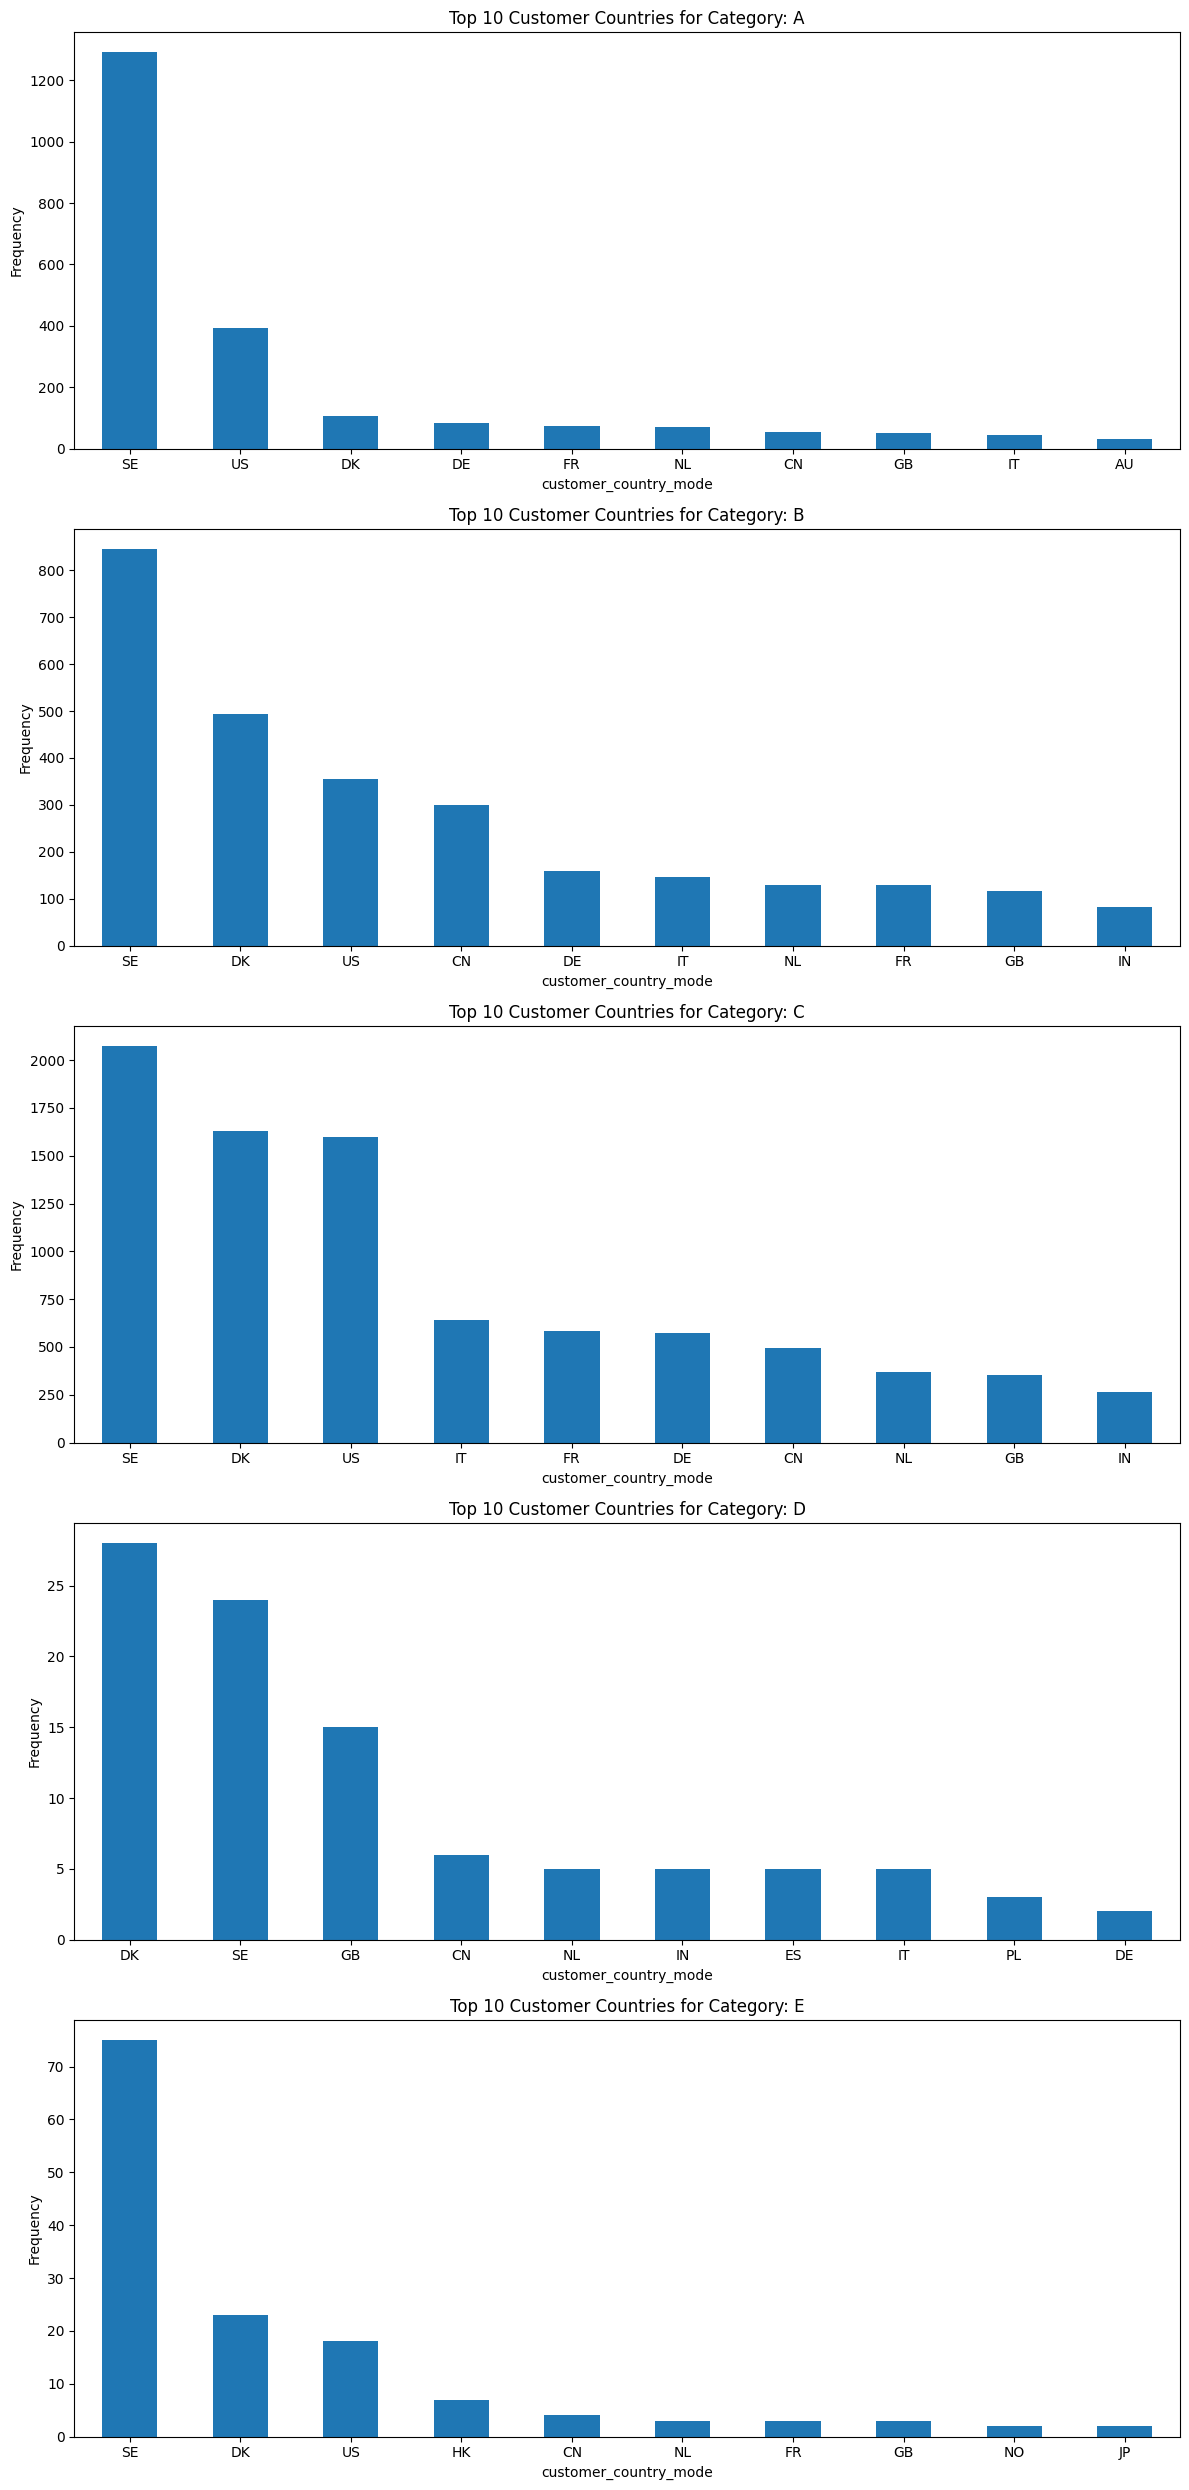

In [38]:
# Assuming 'A-E' is the desired order. If there are more categories, expand the list.
desired_order = ['A', 'B', 'C', 'D', 'E']

# Filter and sort the unique categories based on the desired order
unique_categories = [cat for cat in desired_order if cat in df_bertopic_labeled['category_bertopic'].unique()]

n_categories = len(unique_categories)

fig, axs = plt.subplots(n_categories, 1, figsize=(12, 5 * n_categories))

for ax, category in zip(axs, unique_categories):
    category_data = df_bertopic_labeled[df_bertopic_labeled['category_bertopic'] == category]
    top_countries = category_data['customer_country_mode'].value_counts().head(10)
    top_countries.plot(kind='bar', ax=ax)
    ax.set_title(f'Top 10 Customer Countries for Category: {category}')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
save_figure(fig, 'bertopic_labeled_top_customer_countries_combined')
plt.show()

### LazyPredict

In [39]:
cat_columns = ['customer_country_mode', 'month_mode', 'year_mode', 'quarter_mode', 'day_week_mode']
num_columns = []
log_trans_columns = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_id_count','customer_country_count']

In [40]:
pipeline = PreprocessingPipeline(cat_columns, num_columns, log_trans_columns)
df_transformed = pipeline.fit_transform(df_bertopic_labeled)
transformed_df_with_headers = pipeline.get_transformed_df()

Visualize transformed data

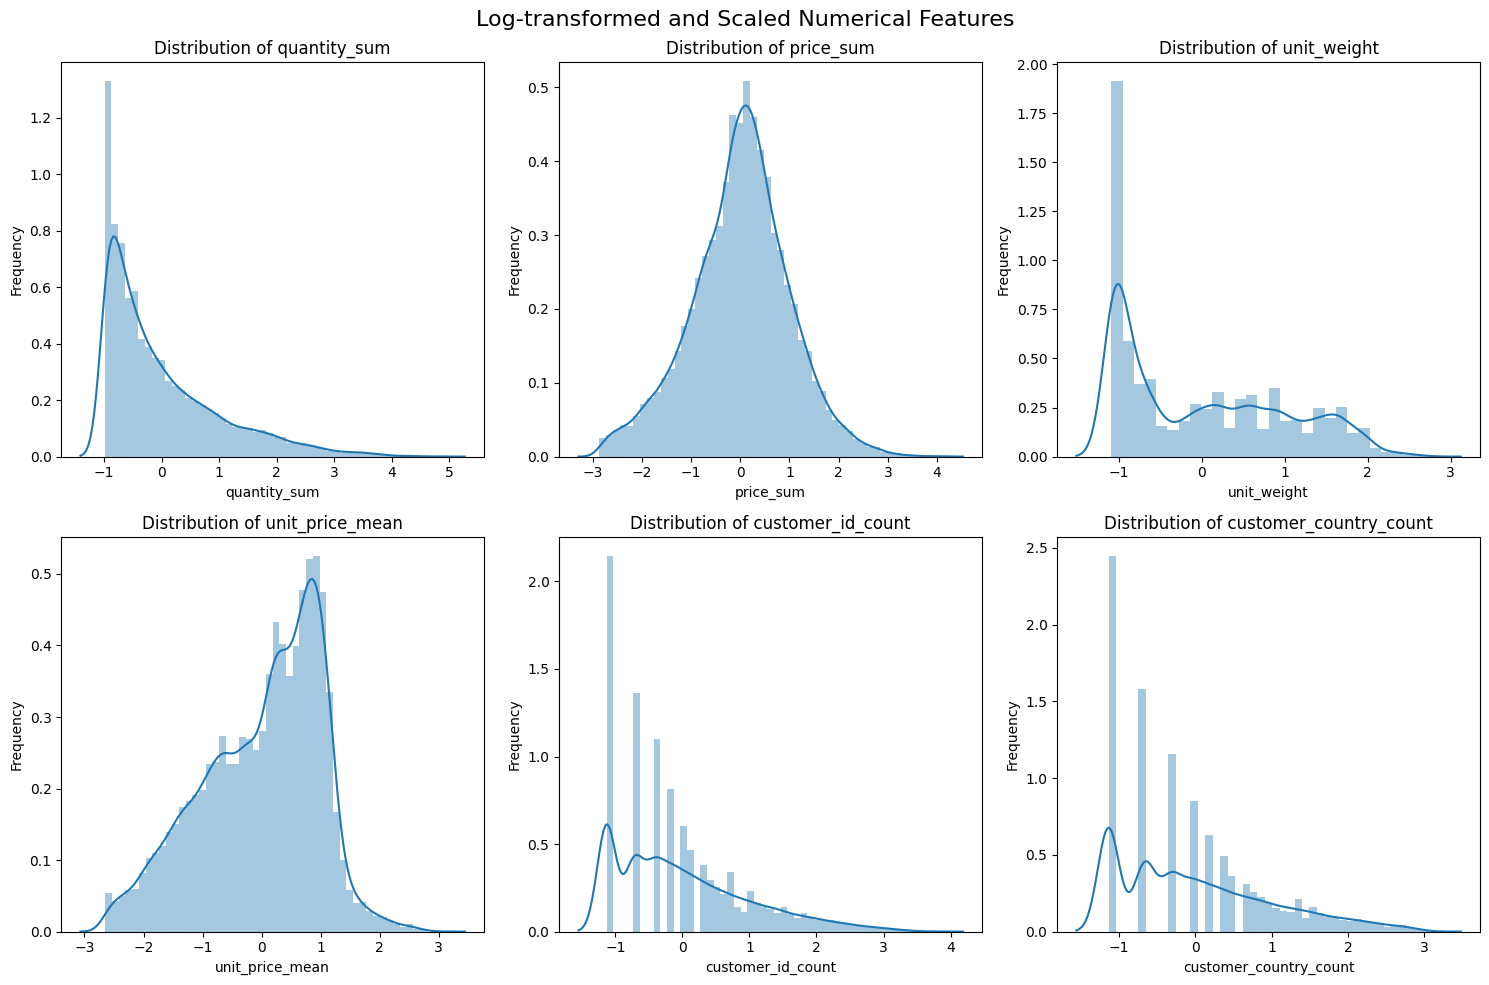

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to plot
features = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_id_count', 'customer_country_count']

# Create subplots
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for idx, feature in enumerate(features):
    row = idx // n_cols
    col = idx % n_cols
    sns.distplot(transformed_df_with_headers[feature], kde=True, ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of {feature}')
    axs[row, col].set_ylabel('Frequency')

# Add a main title to the subplots
fig.suptitle('Log-transformed and Scaled Numerical Features', fontsize=16)

# Adjust subplot parameters to fit the main title
fig.subplots_adjust(top=0.92)

plt.tight_layout()

# Save the figure
save_figure(fig, 'bertopic_labeled_transformed_multiple_histograms')

plt.show()


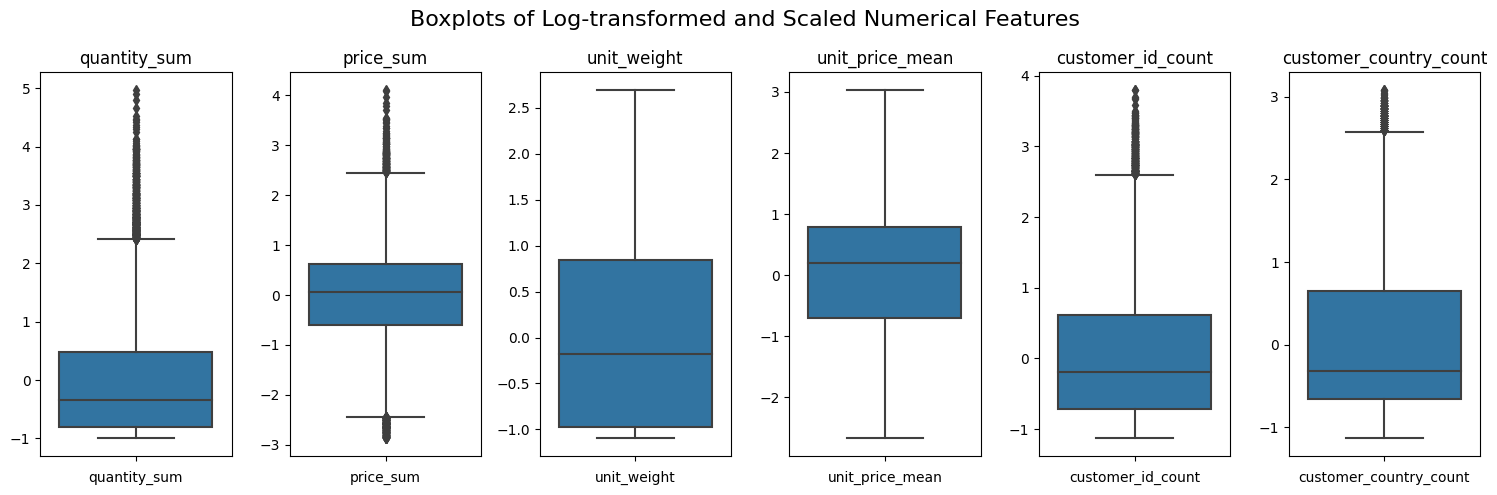

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to plot
features = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_id_count', 'customer_country_count']

# Setting up the figure and axis
fig, axs = plt.subplots(1, len(features), figsize=(15, 5))

# Loop over each feature and plot a boxplot on its respective axis
for i, feature in enumerate(features):
    sns.boxplot(y=transformed_df_with_headers[feature], ax=axs[i])
    axs[i].set_title(f'{feature}')
    axs[i].set_ylabel('')  # To avoid repeated y-labels
    axs[i].set_xlabel(feature)

# Add a main title to the subplots
fig.suptitle('Boxplots of Log-transformed and Scaled Numerical Features', fontsize=16)

# Adjust subplot parameters to fit the main title
fig.subplots_adjust(top=0.92)

plt.tight_layout()

# Save the figure
save_figure(fig, 'bertopic_labeled_transformed_multiple_boxplots')

plt.show()

In [42]:
# Run LazyPredict
lazy_pipeline = LazyPredictPipeline(df_bertopic_labeled, 'category_bertopic', cat_columns, num_columns, log_trans_columns)
models, predictions = lazy_pipeline.run()

 90%|████████▉ | 26/29 [03:59<00:21,  7.17s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1446
[LightGBM] [Info] Number of data points in the train set: 14635, number of used features: 82
[LightGBM] [Info] Start training from score -1.985281
[LightGBM] [Info] Start training from score -1.642080
[LightGBM] [Info] Start training from score -0.424887
[LightGBM] [Info] Start training from score -5.069383
[LightGBM] [Info] Start training from score -4.715974


100%|██████████| 29/29 [04:02<00:00,  8.35s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 11708, number of used features: 77
[LightGBM] [Info] Start training from score -1.985281
[LightGBM] [Info] Start training from score -1.642256
[LightGBM] [Info] Start training from score -0.424913
[LightGBM] [Info] Start training from score -5.063963
[LightGBM] [Info] Start training from score -4.714067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 11708, number of used features: 79
[LightGBM] [Info] Start training from score -1.985281
[LightGBM] [Info] Start training f

In [43]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken,Cross_Val_Score
Model,,,,,,
LGBMClassifier,0.81,0.56,None,0.80,2.26,0.81
BaggingClassifier,0.80,0.52,None,0.80,1.45,0.79
DecisionTreeClassifier,0.73,0.46,None,0.73,0.39,0.73
SGDClassifier,0.69,0.46,None,0.63,1.76,0.71
NearestCentroid,0.53,0.44,None,0.57,0.17,0.49
RandomForestClassifier,0.78,0.43,None,0.76,1.89,0.78
LogisticRegression,0.72,0.43,None,0.66,12.89,0.71
AdaBoostClassifier,0.74,0.41,None,0.71,2.32,0.67
ExtraTreeClassifier,0.67,0.39,None,0.67,0.12,0.62
